In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scikit_posthocs import posthoc_dunn
from scipy.stats import f_oneway, shapiro, levene, kruskal

In [3]:
dir = "PC-GITA_per_task_16000Hz/processed_audio_all"

# Dictionary to store mean SI-SDR values for each scenario
scenario_means = {}

# List of all dataframes and list of all file names
dfs = [pd.read_csv(os.path.join(dir, file), delimiter=' ', header=None, skiprows=1) for file in os.listdir(dir)]
file_names = [os.path.splitext(file)[0] for file in os.listdir(dir)]
file_names = [file.replace('_', ' ').title() for file in file_names]

for i in range(len(dfs)):

    df = dfs[i]

    # Drop last column (NaN column added in the end because of a space in the end of each line)
    df = df.drop(df.columns[[-1]], axis=1)
    # Drop first column (index column added in the beginning)
    df = df.drop(df.columns[[0]], axis=1)
    # Rename columns and add a column with the scenario name
    df.columns = ['Audio1', 'Audio2', 'SI_SDR_y', 'SI_SDR_sep', 'SI_SDR_resep']
    df['Scenario'] = file_names[i]

    # Calculate the mean SI-SDR values and store them in the dictionary
    mean_SI_SDR_y = df['SI_SDR_y'].mean()
    mean_SI_SDR_sep = df['SI_SDR_sep'].mean()
    mean_SI_SDR_resep = df['SI_SDR_resep'].mean()
    scenario_means[file_names[i]] = {'Avg SISDR Before': mean_SI_SDR_y, 'Avg SISDR SepFormer': mean_SI_SDR_sep, 'Avg SISDR RE-SepFormer': mean_SI_SDR_resep}

    dfs[i] = df


# Create a DataFrame from the mean values
means_df = pd.DataFrame.from_dict(scenario_means, orient='index')

# Calculate the overall performance by taking the mean of the mean values for each scenario
means_df['Overall Performance'] = means_df[['Avg SISDR Before', 'Avg SISDR SepFormer', 'Avg SISDR RE-SepFormer']].mean(axis=1)

# Sort the dataframe by the 'Overall Performance' column in descending order
sorted_means_df = means_df.sort_values(by='Overall Performance', ascending=False)

## Average SISDR for Each Scenario

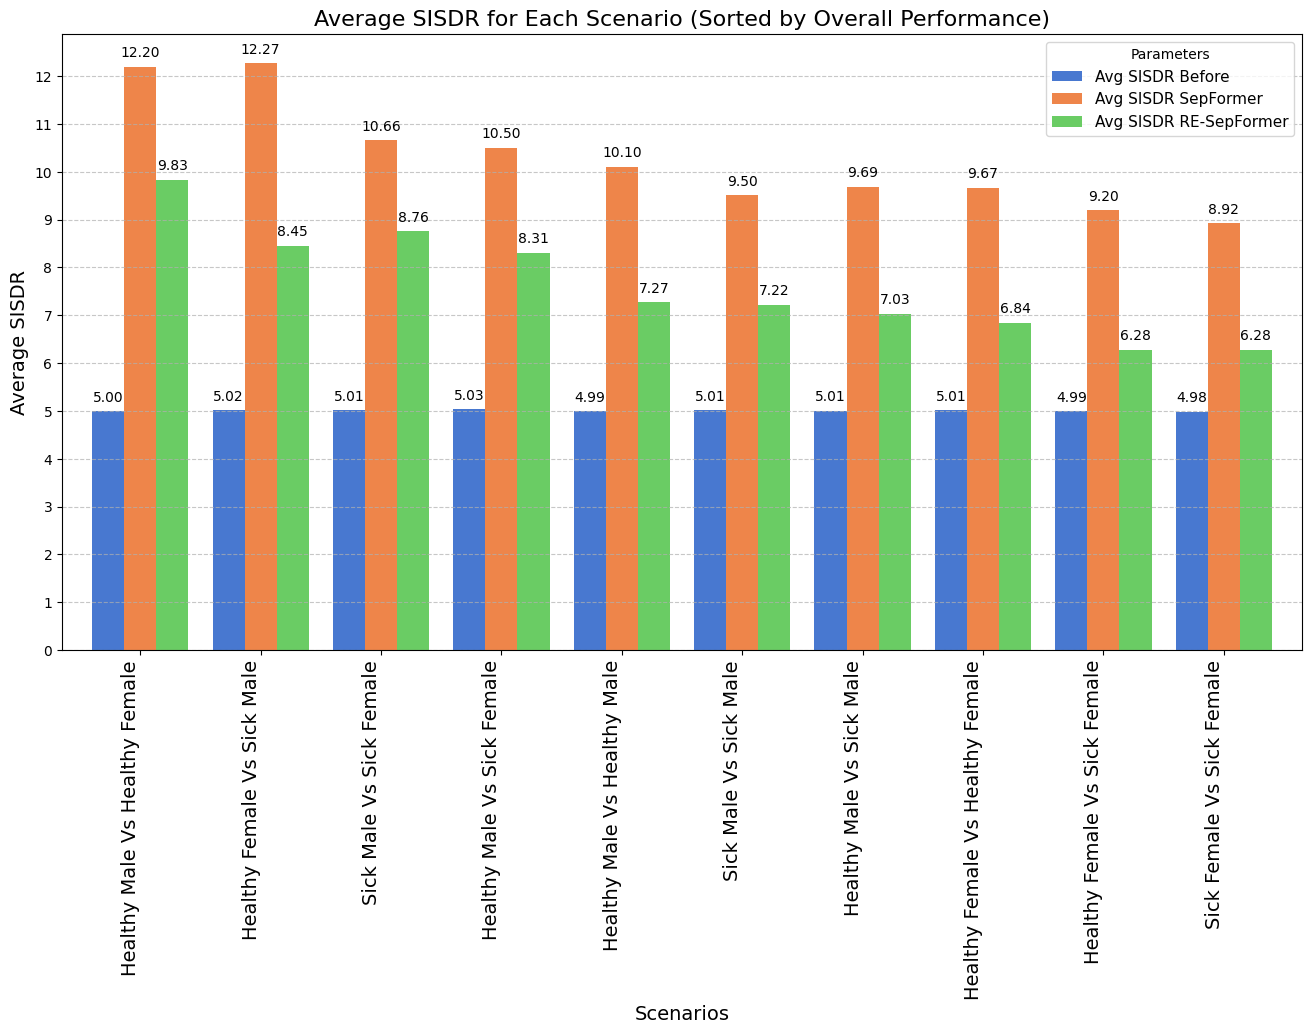

In [4]:
# Plot the 3 average SISDR for each scenario
ax = sorted_means_df.drop('Overall Performance', axis=1).plot(kind='bar', figsize=(16, 8), color=sns.color_palette('muted'), width=0.8)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_yticks(range(0, int(sorted_means_df.max().max()) + 1))  # Set y-axis grid lines at every 1 unit
ax.set_xticklabels(sorted_means_df.index, rotation=90, ha='right', fontsize=14)

ax.set_title('Average SISDR for Each Scenario (Sorted by Overall Performance)', fontsize=16)
ax.set_xlabel('Scenarios', fontsize=14)
ax.set_ylabel('Average SISDR', fontsize=14)
ax.legend(title='Parameters', fontsize=11)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.show()

In [5]:
# Filter the dataframe to only include the scenarios for healthy speakers
selected_indices = ["Healthy Male Vs Healthy Female", "Healthy Female Vs Healthy Female", "Healthy Male Vs Healthy Male"]
filtered_df = sorted_means_df[sorted_means_df.index.isin(selected_indices)]

# Print the value of Avg SISDR SepFormer and Avg SISDR RE-SepForme
for index in selected_indices:
    sepformer_avg_sisdr = filtered_df.loc[filtered_df.index == index, 'Avg SISDR SepFormer'].values[0]
    resepformer_avg_sisdr = filtered_df.loc[filtered_df.index == index, 'Avg SISDR RE-SepFormer'].values[0]

    print(f"{index}: Avg SISDR SepFormer = {sepformer_avg_sisdr}, Avg SISDR RE-SepFormer = {resepformer_avg_sisdr}")
# compute mean 
sepformer_avg_sisdr = filtered_df['Avg SISDR SepFormer'].mean()
resepformer_avg_sisdr = filtered_df['Avg SISDR RE-SepFormer'].mean()
print(f"Overall: Avg SISDR SepFormer = {sepformer_avg_sisdr}, Avg SISDR RE-SepFormer = {resepformer_avg_sisdr}")


Healthy Male Vs Healthy Female: Avg SISDR SepFormer = 12.200790025678735, Avg SISDR RE-SepFormer = 9.830963090445643
Healthy Female Vs Healthy Female: Avg SISDR SepFormer = 9.666579411307563, Avg SISDR RE-SepFormer = 6.842349889140748
Healthy Male Vs Healthy Male: Avg SISDR SepFormer = 10.104019586324913, Avg SISDR RE-SepFormer = 7.272777681021602
Overall: Avg SISDR SepFormer = 10.657129674437071, Avg SISDR RE-SepFormer = 7.982030220202664


## Box Plot of the SISDR's for Each Scenario

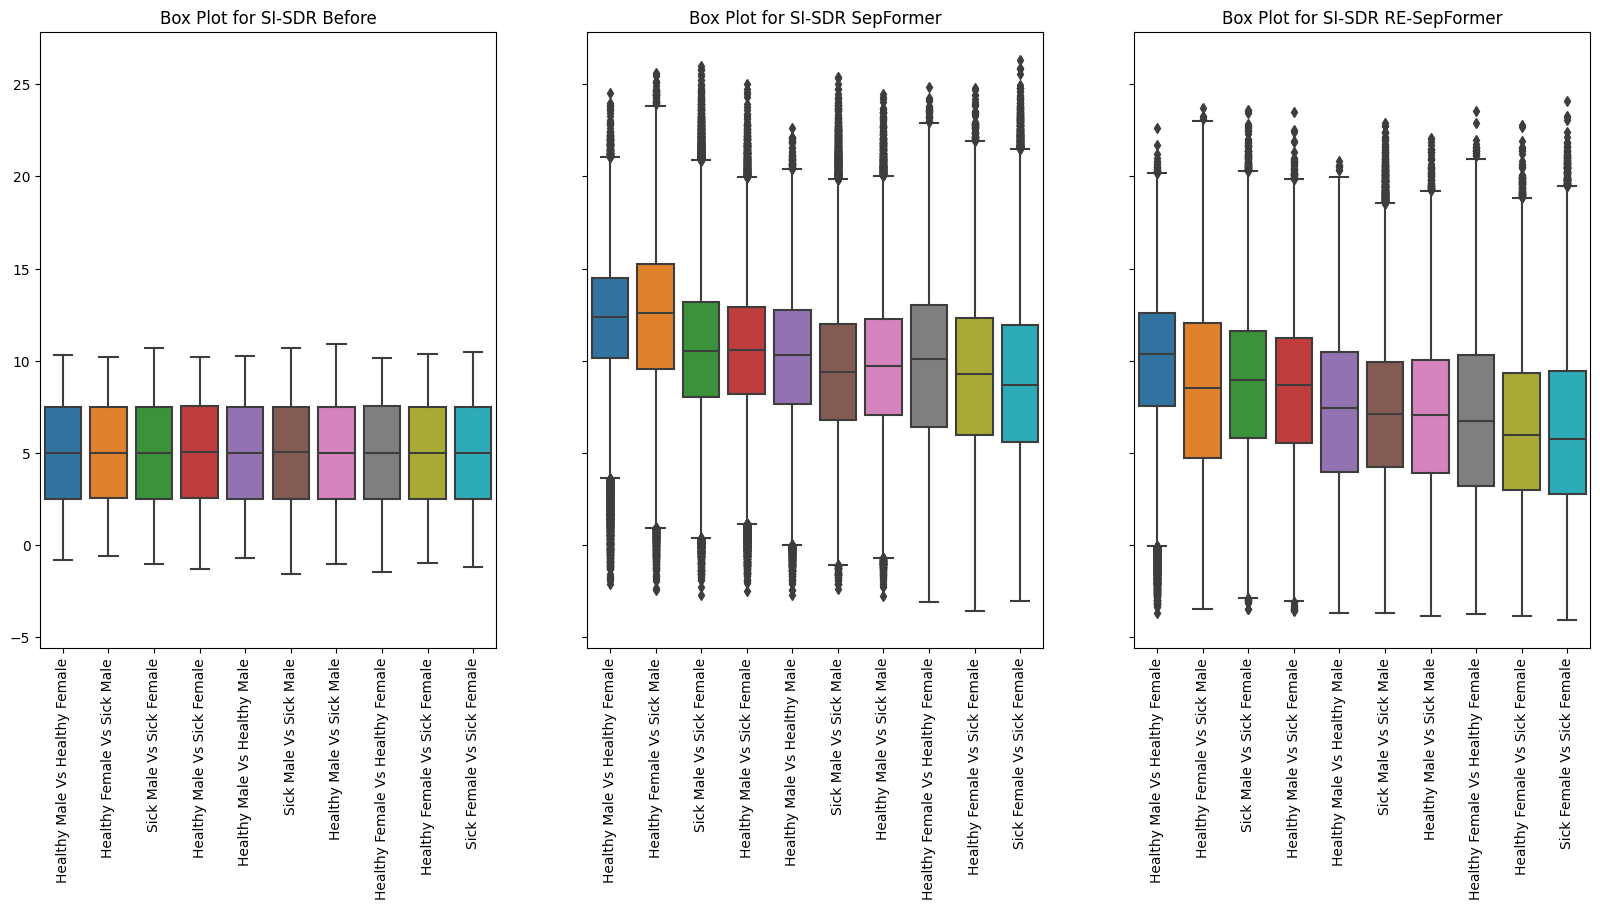

In [12]:
combined_data_y = pd.concat([df[['Scenario', 'SI_SDR_y']] for df in dfs])
combined_data_sep = pd.concat([df[['Scenario', 'SI_SDR_sep']] for df in dfs])
combined_data_resep = pd.concat([df[['Scenario', 'SI_SDR_resep']] for df in dfs])

# sort combined data in same order as sorted_means_df
combined_data_y['Scenario'] = pd.Categorical(combined_data_y['Scenario'], sorted_means_df.index)
combined_data_y = combined_data_y.sort_values('Scenario')
combined_data_sep['Scenario'] = pd.Categorical(combined_data_sep['Scenario'], sorted_means_df.index)
combined_data_sep = combined_data_sep.sort_values('Scenario')
combined_data_resep['Scenario'] = pd.Categorical(combined_data_resep['Scenario'], sorted_means_df.index)
combined_data_resep = combined_data_resep.sort_values('Scenario')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)

# Box plot for SI_SDR_y
sns.boxplot(x='Scenario', y='SI_SDR_y', data=combined_data_y, ax=axes[0])
axes[0].set_title('Box Plot for SI-SDR Before')
axes[0].tick_params(axis='x', rotation=90)

# Box plot for SI_SDR_sep
sns.boxplot(x='Scenario', y='SI_SDR_sep', data=combined_data_sep, ax=axes[1])
axes[1].set_title('Box Plot for SI-SDR SepFormer')
axes[1].tick_params(axis='x', rotation=90)

# Box plot for SI_SDR_resep
sns.boxplot(x='Scenario', y='SI_SDR_resep', data=combined_data_resep, ax=axes[2])
axes[2].set_title('Box Plot for SI-SDR RE-SepFormer')
axes[2].tick_params(axis='x', rotation=90)

#remove axis legend
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

plt.show()


## Statistical Testing

### Which test to use ?

In [7]:
columns_to_test = ['SI_SDR_y', 'SI_SDR_sep', 'SI_SDR_resep']

for column in columns_to_test:
    data = [df[column].dropna() for df in dfs]

    # Check Normality
    normality_p_values = [shapiro(group)[1] for group in data]
    if all(p_value > 0.05 for p_value in normality_p_values):
        print(f"{column}: Data is approximately normally distributed.")
    else:
        print(f"{column}: Data may not be normally distributed.")

    # Check Homogeneity of Variances
    levene_statistic, levene_p_value = levene(*data)
    if levene_p_value > 0.05:
        print(f"{column}: Homogeneity of variances is supported (p-value = {levene_p_value:.4f}).")
    else:
        print(f"{column}: Homogeneity of variances may not be met.")


c:\Users\danak\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


SI_SDR_y: Data may not be normally distributed.
SI_SDR_y: Homogeneity of variances is supported (p-value = 0.5163).
SI_SDR_sep: Data may not be normally distributed.
SI_SDR_sep: Homogeneity of variances may not be met.
SI_SDR_resep: Data may not be normally distributed.
SI_SDR_resep: Homogeneity of variances may not be met.


The data for SI_SDR_y, SI_SDR_sep, and SI_SDR_resep did not meet the assumptions required for one-way ANOVA. The Shapiro-Wilk test suggests non-normality in all cases, and Levene's test indicates a lack of homogeneity of variances for SI_SDR_sep and SI_SDR_resep. Given these information, we will use the Kruskal-Wallis test, which is robust to such conditions.

### Kruskal-Wallis Tests

In [8]:
# Perform Kruskal-Wallis test
for column in columns_to_test:
    data = [df[column].dropna() for df in dfs]
    h_statistic, p_value = kruskal(*data)
    print(f"Kruskal-Wallis test for {column}: H-statistic = {h_statistic}, p-value = {p_value}")

Kruskal-Wallis test for SI_SDR_y: H-statistic = 12.63218085491526, p-value = 0.17996806179071692
Kruskal-Wallis test for SI_SDR_sep: H-statistic = 39072.31686075896, p-value = 0.0
Kruskal-Wallis test for SI_SDR_resep: H-statistic = 35798.70152730786, p-value = 0.0


The Kruskal-Wallis test for SI_SDR_y yields a p-value of 0.17997, which is greater than the significance level of 0.05. Therefore, there is insufficient evidence to reject the null hypothesis that the medians of the groups are equal. This suggests that there is no significant difference in SI_SDR_y values across the different groups.

The Kruskal-Wallis test for SI_SDR_sep yields a very small p-value approaching zero. Therefore, the null hypothesis is rejected, suggesting a significant difference in SI_SDR_sep values among the groups. This indicates that at least one group has a different median SI_SDR_sep value compared to the others.

The Kruskal-Wallis test for SI_SDR_resep yields a very small p-value approaching zero. Therefore, the null hypothesis is rejected, suggesting a significant difference in SI_SDR_resep values among the groups. This indicates that at least one group has a median SI_SDR_resep value that differs from the others.

Therefore, the statistical evidence supports the notion that the performance of both SepFormer and RE-Sepformer differs significantly among the scenarios.

### Dunn's Tests

After finding overall statistical differences via Kruskal-Wallis tests, the Dunn's test pinpoints which scenarios specifically differ from one another. The significance matrices obtained from Dunn's test show whether there are statistically significant differences between pairs of scenarios for each variable (SI_SDR_y, SI_SDR_sep, SI_SDR_resep). In the matrices, "True" indicates significance, while "False" indicates no significance.

In [9]:
# Perform Dunn's test
alpha = 0.05

# print file_names with its index
print('\n'.join(f'{i+1}: {file_names[i]}' for i in range(len(file_names))))
print('\n')


for column in ['SI_SDR_sep', 'SI_SDR_resep']:
    data = [df[column].dropna().values for df in dfs]
    dunn_results = posthoc_dunn(data, p_adjust='bonferroni')    

    # Create a matrix of boolean values indicating significance
    significant_matrix = pd.DataFrame(index=dunn_results.index, columns=dunn_results.columns[:-1], dtype=bool)
    significant_matrix = dunn_results.applymap(lambda x: x < alpha)

    print(f"Significance matrix for {column}:")
    print(significant_matrix)
    print('\n')

1: Healthy Female Vs Healthy Female
2: Healthy Female Vs Sick Female
3: Healthy Female Vs Sick Male
4: Healthy Male Vs Healthy Female
5: Healthy Male Vs Healthy Male
6: Healthy Male Vs Sick Female
7: Healthy Male Vs Sick Male
8: Sick Female Vs Sick Female
9: Sick Male Vs Sick Female
10: Sick Male Vs Sick Male


Significance matrix for SI_SDR_sep:
       1      2      3      4      5      6      7      8      9      10
1   False   True   True   True   True   True   True   True   True   True
2    True  False   True   True   True   True   True   True   True   True
3    True   True  False   True   True   True   True   True   True   True
4    True   True   True  False   True   True   True   True   True   True
5    True   True   True   True  False   True   True   True   True   True
6    True   True   True   True   True  False   True   True  False   True
7    True   True   True   True   True   True  False   True   True   True
8    True   True   True   True   True   True   True  False   True  

SI_SDR_y: No significant differences were found between any pairs of scenarios for SI_SDR_y, suggesting that the performance in terms of SI_SDR_y is statistically similar across all scenarios.  

SI_SDR_sep: The widespread presence of "True" values suggests that nearly all pairs of scenarios have statistically significantly different performances. This indicates that the choice of scenario significantly influences how well the source separation algorithms work. 

SI_SDR_resep: The widespread presence of "True" values suggests that nearly all pairs of scenarios have statistically significantly different performances. This indicates that the choice of scenario significantly influences how well the source separation algorithms work. 

